In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import vector
import mplhep

In [3]:
batchSize = 1024
path_data = '../../dataset/v7/'
device = torch.device('cpu')

path_unscaled = 'preTraining-MEMFlow_2_v9/unscaledRegressedPartonsTensor.pt'

In [4]:
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=[],
                        parton_list=['data_higgs_t_tbar_ISR_cartesian'])

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files


In [5]:
unscaledTensor = torch.load(path_unscaled)

data_regressed = torch.sign(unscaledTensor)*(torch.exp(torch.abs(unscaledTensor)) - 1)

higgs = vector.array(
    {
        "E": data_regressed[:,0,0].detach().numpy(),
        "px": data_regressed[:,0,1].detach().numpy(),
        "py": data_regressed[:,0,2].detach().numpy(),
        "pz": data_regressed[:,0,3].detach().numpy(),
    }
)

thad = vector.array(
    {
        "E": data_regressed[:,1,0].detach().numpy(),
        "px": data_regressed[:,1,1].detach().numpy(),
        "py": data_regressed[:,1,2].detach().numpy(),
        "pz": data_regressed[:,1,3].detach().numpy(),
    }
)

tlep = vector.array(
    {
        "E": data_regressed[:,2,0].detach().numpy(),
        "px": data_regressed[:,2,1].detach().numpy(),
        "py": data_regressed[:,2,2].detach().numpy(),
        "pz": data_regressed[:,2,3].detach().numpy(),
    }
)

glISR = vector.array(
    {
        "E": data_regressed[:,3,0].detach().numpy(),
        "px": data_regressed[:,3,1].detach().numpy(),
        "py": data_regressed[:,3,2].detach().numpy(),
        "pz": data_regressed[:,3,3].detach().numpy(),
    }
)

print(unscaledTensor.shape)

torch.Size([569993, 4, 4])


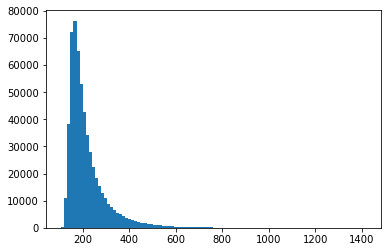

In [6]:
x = plt.hist(higgs["E"], bins=100)

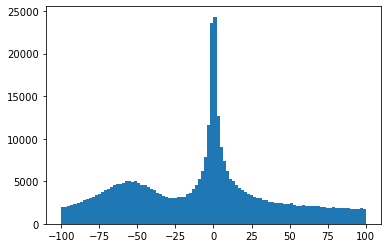

In [7]:
x = plt.hist(higgs["px"], bins=100, range=(-100,100))

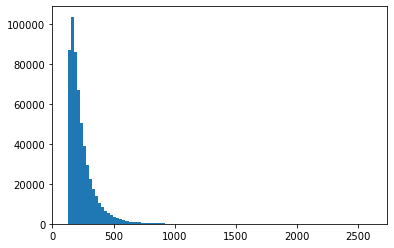

In [8]:
x = plt.hist(higgsCorrect["E"], bins=100)

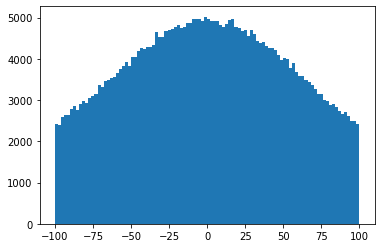

In [9]:
x = plt.hist(higgsCorrect["px"], bins=100, range=(-100,100))

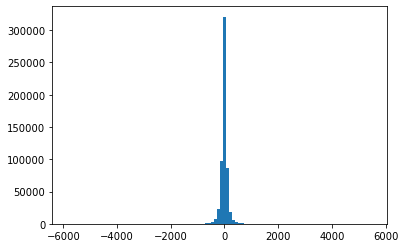

In [10]:
x = plt.hist(higgsCorrect["pz"] - higgs["pz"], bins=100)

# Plot eta

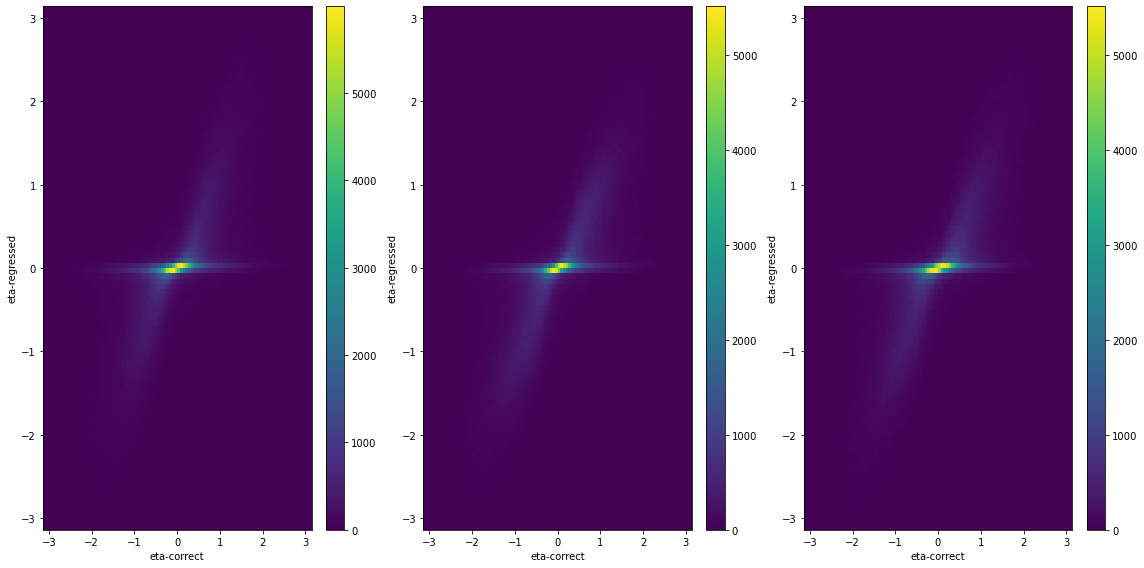

In [11]:
pi = torch.pi

# Quick construction, no other imports needed:
hist2d_eta_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
  .Double())

hist2d_eta_higgs.fill(higgsCorrect.eta,
                higgs.eta)
    
hist2d_eta_thad.fill(thadCorrect.eta,
                thad.eta)
    
hist2d_eta_tlep.fill(tlepCorrect.eta,
                tlep.eta)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_tlep, ax=axs[2])

plt.tight_layout()

# makessense to be worse because eta is related to pz

# Plot E, px, py, pz for thad

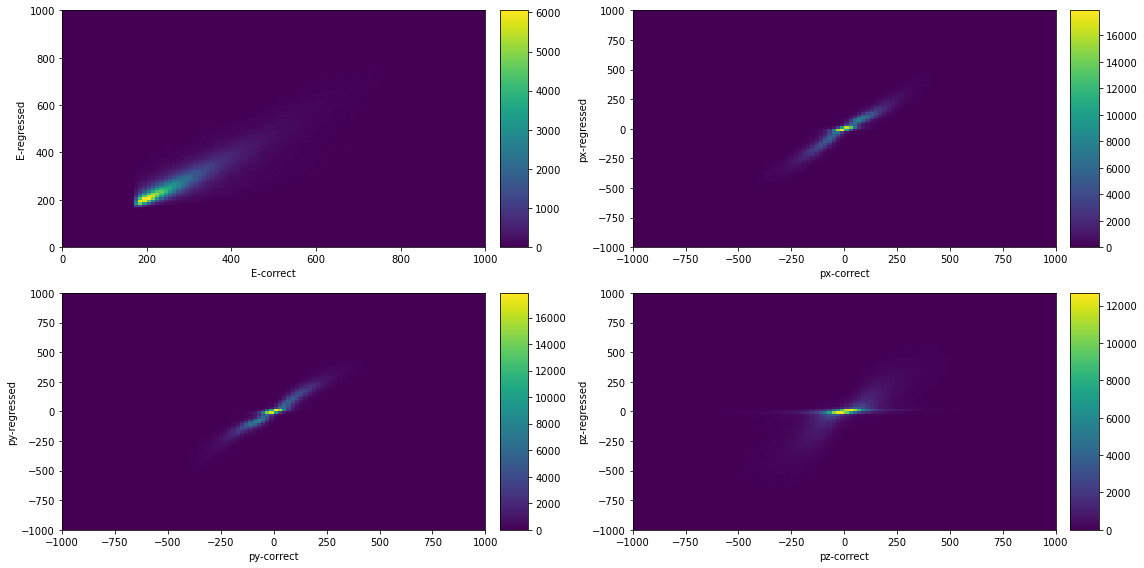

In [12]:
hist2d_E_thad = (
  Hist.new
  .Reg(bins=100, start=0, stop=1000, name="E-correct", label="E-correct")
  .Reg(bins=100, start=0, stop=1000, name="E-regressed", label="E-regressed")
  .Double())

hist2d_px_thad = (
  Hist.new
  .Reg(bins=100, start=-1000, stop=1000, name="px-correct", label="px-correct")
  .Reg(bins=100, start=-1000, stop=1000, name="px-regressed", label="px-regressed")
  .Double())

hist2d_py_thad = (
  Hist.new
  .Reg(bins=100, start=-1000, stop=1000, name="py-correct", label="py-correct")
  .Reg(bins=100, start=-1000, stop=1000, name="py-regressed", label="py-regressed")
  .Double())

hist2d_pz_thad = (
  Hist.new
  .Reg(bins=100, start=-1000, stop=1000, name="pz-correct", label="pz-correct")
  .Reg(bins=100, start=-1000, stop=1000, name="pz-regressed", label="pz-regressed")
  .Double())

hist2d_E_thad.fill(thadCorrect.E,
                thad.E)

hist2d_px_thad.fill(thadCorrect.px,
                thad.px)

hist2d_py_thad.fill(thadCorrect.py,
                thad.py)

hist2d_pz_thad.fill(thadCorrect.pz,
                thad.pz)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

mplhep.hist2dplot(hist2d_E_thad, ax=axs[0, 0])

mplhep.hist2dplot(hist2d_px_thad, ax=axs[0, 1])

mplhep.hist2dplot(hist2d_py_thad, ax=axs[1, 0])

mplhep.hist2dplot(hist2d_pz_thad, ax=axs[1, 1])

plt.tight_layout()

# Plot phi

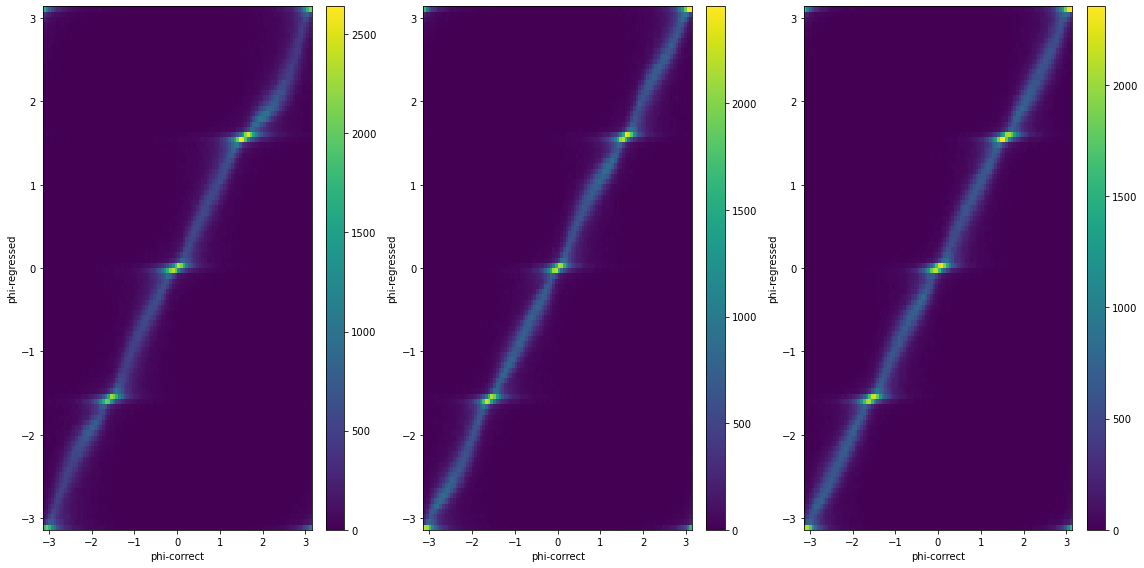

In [13]:
# Quick construction, no other imports needed:
hist2d_phi_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
  .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
  .Double())

hist2d_phi_higgs.fill(higgsCorrect.phi,
                higgs.phi)
    
hist2d_phi_thad.fill(thadCorrect.phi,
                thad.phi)
    
hist2d_phi_tlep.fill(tlepCorrect.phi,
                tlep.phi)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_phi_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_phi_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_phi_tlep, ax=axs[2])

plt.tight_layout()

# Plot pt

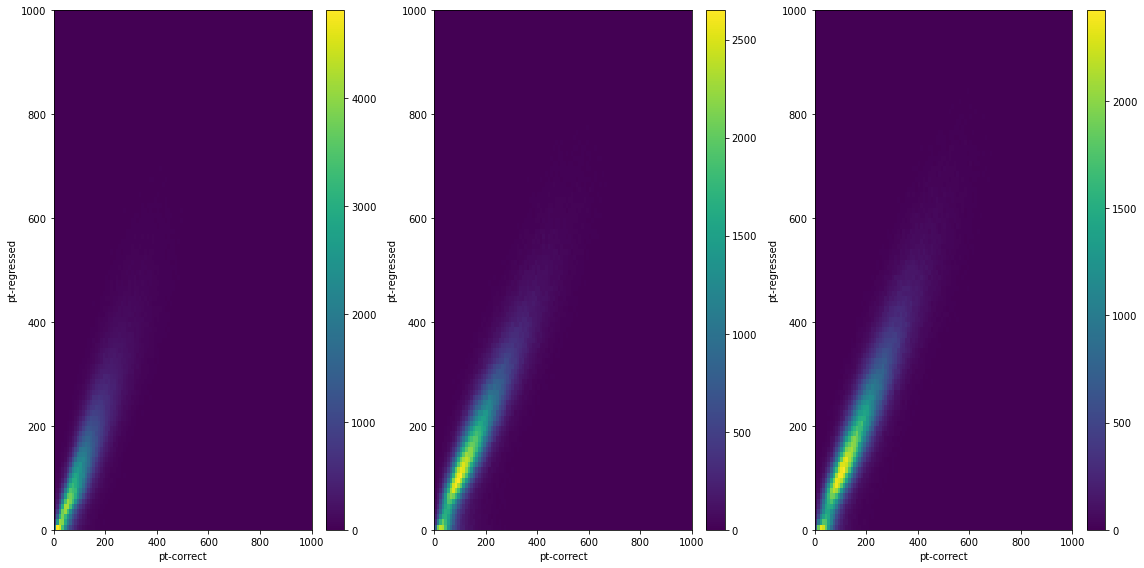

In [14]:
# Quick construction, no other imports needed:
hist2d_pt_higgs = (
  Hist.new
  .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_thad = (
  Hist.new
  .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_tlep = (
  Hist.new
  .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
  .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
  .Double())

hist2d_pt_higgs.fill(higgsCorrect.pt,
                higgs.pt)
    
hist2d_pt_thad.fill(thadCorrect.pt,
                thad.pt)
    
hist2d_pt_tlep.fill(tlepCorrect.pt,
                tlep.pt)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_pt_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_pt_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_pt_tlep, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(pt)

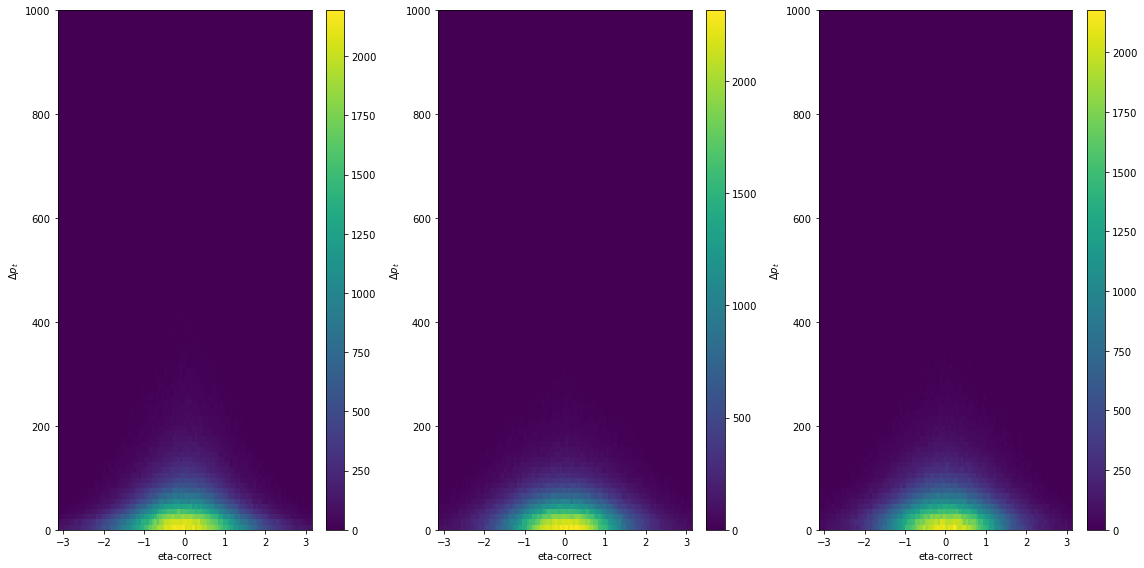

In [15]:
# Quick construction, no other imports needed:
hist2d_eta_Diffpt_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
  .Double())

hist2d_eta_Diffpt_higgs.fill(higgsCorrect.eta,
                np.abs(higgs.pt - higgsCorrect.pt))
    
hist2d_eta_Diffpt_thad.fill(thadCorrect.eta,
                np.abs(thad.pt - thadCorrect.pt))
    
hist2d_eta_Diffpt_tlep.fill(tlepCorrect.eta,
                np.abs(tlep.pt - tlepCorrect.pt))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_Diffpt_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_Diffpt_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_Diffpt_tlep, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(phi)

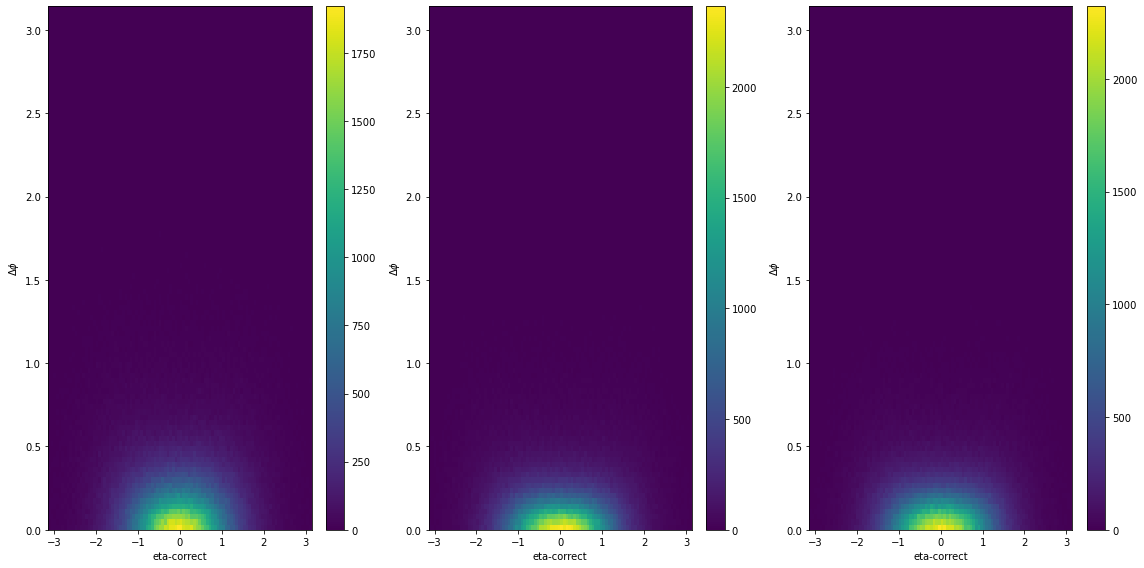

In [16]:
# Quick construction, no other imports needed:
hist2d_eta_Diffphi_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
  .Double())

hist2d_eta_Diffphi_higgs.fill(higgsCorrect.eta,
                np.abs(higgs.phi - higgsCorrect.phi))
    
hist2d_eta_Diffphi_thad.fill(thadCorrect.eta,
                np.abs(thad.phi - thadCorrect.phi))
    
hist2d_eta_Diffphi_tlep.fill(tlepCorrect.eta,
                np.abs(tlep.phi - tlepCorrect.phi))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_Diffphi_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_Diffphi_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_Diffphi_tlep, ax=axs[2])

plt.tight_layout()

# Plot eta vs delta(R)

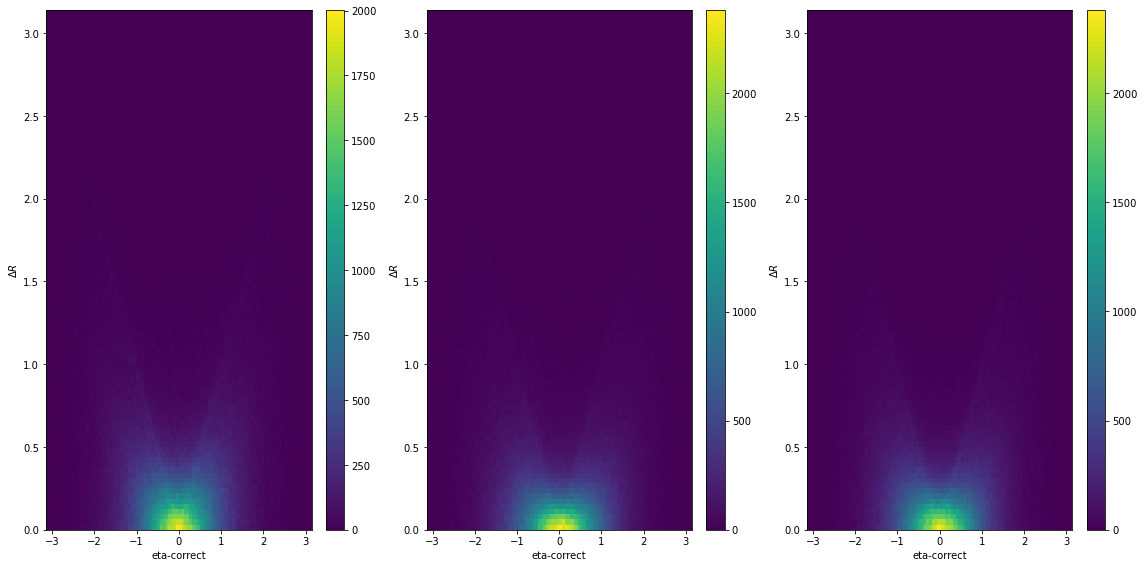

In [17]:
# Quick construction, no other imports needed:
hist2d_eta_DiffR_higgs = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_thad = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_tlep = (
  Hist.new
  .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
  .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
  .Double())

hist2d_eta_DiffR_higgs.fill(higgsCorrect.eta,
                np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2)))
    
hist2d_eta_DiffR_thad.fill(thadCorrect.eta,
                np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2)))
    
hist2d_eta_DiffR_tlep.fill(tlepCorrect.eta,
                np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2)))

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

mplhep.hist2dplot(hist2d_eta_DiffR_higgs, ax=axs[0])

mplhep.hist2dplot(hist2d_eta_DiffR_thad, ax=axs[1])

mplhep.hist2dplot(hist2d_eta_DiffR_tlep, ax=axs[2])

plt.tight_layout()

# Split in matched/unmatched

In [18]:
import awkward as ak

In [19]:
df = ak.from_parquet("../../dataset/v7/all_jets.parquet")

jets = df.jets
partons = df.partons
partons_matched = df.partons_matched
lepton_partons = df.lepton_partons
lepton_reco = df.lepton_reco

# in fiecare event am 4 particule: higgs tlep thad glISR
# vreau sa vad care din astea sunt matched si care nu
# ma uit la jets cu prov = 2 pt higgs si tot asa?

In [20]:
partons[0].type

7 * {"pt": float64, "eta": float64, "phi": float64, "mass": float64, "pdgId": float64, "prov": float64}

In [21]:
partons_matched[0].type

5 * ?{"pt": float64, "eta": float64, "phi": float64, "mass": float64, "pdgId": float64, "prov": float64}

In [22]:
ak.to_numpy(partons[0]["pt"])

array([30.55859375, 73.28515625, 78.609375  , 12.87988281, 40.84570312,
       54.125     , 66.        ])

In [23]:
ak.to_numpy(partons_matched[0]["pt"])

masked_array(data=[78.609375, 73.28515625, --, 30.55859375, 40.845703125],
             mask=[False, False,  True, False, False],
       fill_value=1e+20)

In [24]:
partons[7878].prov

<Array [4, 3, 2, 5, 5, 1, 1] type='7 * float64'>

In [25]:
jets[0]["matched"]

<Array [True, True, False, True, True] type='5 * bool'>

In [26]:
jets[0]["prov"]

<Array [2, 3, -1, 4, 5] type='5 * float64'>

In [27]:
jets[3]["matched"]

<Array [True, True, True, ... True, False] type='7 * bool'>

In [28]:
jets[3]["prov"]

<Array [4, 2, 1, -1, 3, 1, -1] type='7 * float64'>

In [29]:
partons_knownprov = partons_matched[jets.prov != -1]

# Higgs mask

In [30]:
prov1_jets = jets[jets.prov == 1]

In [31]:
prov1 = prov1_jets["prov"]

In [32]:
prov1

<Array [[], [1, 1], [1], ... 1, 1], [1], [1]] type='569993 * var * float64'>

In [33]:
higgs_mask = ak.count(prov1, axis=1) == 2

In [60]:
higgs_mask = ak.to_numpy(higgs_mask) # matched higgs

higgs_mask

array([False,  True, False, ...,  True, False, False])

# thad mask

In [35]:
prov2_jets = jets[jets.prov == 2] # b from hadronic top decay

In [36]:
prov2 = prov2_jets["prov"]

In [37]:
prov2

<Array [[2], [2], [2], ... [2], [2], [2]] type='569993 * var * float64'>

In [38]:
hadb_mask = ak.count(prov2, axis=1) == 1

In [39]:
hadb_mask

<Array [True, True, True, ... True, True, True] type='569993 * bool'>

In [40]:
prov5_jets = jets[jets.prov == 5] # q from hadronic W decay

In [41]:
prov5 = prov5_jets["prov"]

In [42]:
prov5

<Array [[5], [5, 5], [5], ... 5], [5], [], [5]] type='569993 * var * float64'>

In [43]:
hadW_mask = ak.count(prov5, axis=1) == 2

In [44]:
hadW_mask

<Array [False, True, False, ... False, False] type='569993 * bool'>

In [45]:
hadb_mask = ak.to_numpy(hadb_mask)
hadW_mask = ak.to_numpy(hadW_mask)

In [46]:
hadt_mask = np.logical_and(hadb_mask, hadW_mask)

In [47]:
hadt_mask # matched thad

array([False,  True, False, ..., False, False, False])

# tlep mask

In [48]:
prov3_jets = jets[jets.prov == 3] # b from lept top decay

prov3 = prov3_jets["prov"]

prov3

<Array [[3], [3], [3], ... [3], [3], [3]] type='569993 * var * float64'>

In [49]:
lepb_mask = ak.count(prov3, axis=1) == 1

lepb_mask

<Array [True, True, True, ... True, True, True] type='569993 * bool'>

In [50]:
x = lepton_reco.pt < 0
ak.any(x) # all elements from x are false => all leptons matched

False

In [59]:
tlep_mask = lepb_mask

tlep_mask = ak.to_numpy(tlep_mask)

tlep_mask

array([ True,  True,  True, ...,  True,  True,  True])

# matched plots

In [139]:
def plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
            higgs_mask=1, thad_mask=1, tlep_mask=1):
    
    
    # Quick construction, no other imports needed:
    hist2d_eta_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="eta-regressed", label="eta-regressed")
      .Double())

    hist2d_eta_higgs.fill(higgsCorrect.eta[higgs_mask],
                    higgs.eta[higgs_mask])

    hist2d_eta_thad.fill(thadCorrect.eta[thad_mask],
                    thad.eta[thad_mask])

    hist2d_eta_tlep.fill(tlepCorrect.eta[tlep_mask],
                    tlep.eta[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_eta_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_eta_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_eta_tlep, ax=axs[2])

    plt.tight_layout()

    # makessense to be worse because eta is related to pz

In [140]:
def plot_particle(particleCorrect, particle, particle_mask=1):

    hist2d_E_thad = (
      Hist.new
      .Reg(bins=100, start=0, stop=1000, name="E-correct", label="E-correct")
      .Reg(bins=100, start=0, stop=1000, name="E-regressed", label="E-regressed")
      .Double())

    hist2d_px_thad = (
      Hist.new
      .Reg(bins=100, start=-1000, stop=1000, name="px-correct", label="px-correct")
      .Reg(bins=100, start=-1000, stop=1000, name="px-regressed", label="px-regressed")
      .Double())

    hist2d_py_thad = (
      Hist.new
      .Reg(bins=100, start=-1000, stop=1000, name="py-correct", label="py-correct")
      .Reg(bins=100, start=-1000, stop=1000, name="py-regressed", label="py-regressed")
      .Double())

    hist2d_pz_thad = (
      Hist.new
      .Reg(bins=100, start=-1000, stop=1000, name="pz-correct", label="pz-correct")
      .Reg(bins=100, start=-1000, stop=1000, name="pz-regressed", label="pz-regressed")
      .Double())

    hist2d_E_thad.fill(particleCorrect.E[particle_mask],
                    particle.E[particle_mask])

    hist2d_px_thad.fill(particleCorrect.px[particle_mask],
                    particle.px[particle_mask])

    hist2d_py_thad.fill(particleCorrect.py[particle_mask],
                    particle.py[particle_mask])

    hist2d_pz_thad.fill(particleCorrect.pz[particle_mask],
                    particle.pz[particle_mask])

    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_E_thad, ax=axs[0, 0])

    mplhep.hist2dplot(hist2d_px_thad, ax=axs[0, 1])

    mplhep.hist2dplot(hist2d_py_thad, ax=axs[1, 0])

    mplhep.hist2dplot(hist2d_pz_thad, ax=axs[1, 1])

    plt.tight_layout()

In [141]:
def plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
            higgs_mask=1, thad_mask=1, tlep_mask=1):

# Quick construction, no other imports needed:
    hist2d_phi_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="phi-correct", label="phi-correct")
      .Reg(bins=100, start=-pi, stop=pi, name="phi-regressed", label="phi-regressed")
      .Double())

    hist2d_phi_higgs.fill(higgsCorrect.phi[higgs_mask],
                    higgs.phi[higgs_mask])

    hist2d_phi_thad.fill(thadCorrect.phi[thad_mask],
                    thad.phi[thad_mask])

    hist2d_phi_tlep.fill(tlepCorrect.phi[tlep_mask],
                    tlep.phi[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_phi_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_phi_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_phi_tlep, ax=axs[2])

    plt.tight_layout()

In [142]:
def plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
           higgs_mask=1, thad_mask=1, tlep_mask=1):

    hist2d_pt_higgs = (
      Hist.new
      .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_thad = (
      Hist.new
      .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_tlep = (
      Hist.new
      .Reg(bins=100, start=0, stop=1000, name="pt-correct", label="pt-correct")
      .Reg(bins=100, start=0, stop=1000, name="pt-regressed", label="pt-regressed")
      .Double())

    hist2d_pt_higgs.fill(higgsCorrect.pt[higgs_mask],
                    higgs.pt[higgs_mask])

    hist2d_pt_thad.fill(thadCorrect.pt[thad_mask],
                    thad.pt[thad_mask])

    hist2d_pt_tlep.fill(tlepCorrect.pt[tlep_mask],
                    tlep.pt[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_pt_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_pt_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_pt_tlep, ax=axs[2])

    plt.tight_layout()

In [143]:
def plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
                   higgs_mask=1, thad_mask=1, tlep_mask=1):

# Quick construction, no other imports needed:
    hist2d_eta_Diffpt_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=1000, name="$\Delta p_t$", label="$\Delta p_t$")
      .Double())

    hist2d_eta_Diffpt_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(higgs.pt - higgsCorrect.pt)[higgs_mask])

    hist2d_eta_Diffpt_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(thad.pt - thadCorrect.pt)[thad_mask])

    hist2d_eta_Diffpt_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(tlep.pt - tlepCorrect.pt)[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_eta_Diffpt_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_eta_Diffpt_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_eta_Diffpt_tlep, ax=axs[2])

    plt.tight_layout()

In [144]:
def plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
                    higgs_mask=1, thad_mask=1, tlep_mask=1):

# Quick construction, no other imports needed:
    hist2d_eta_Diffphi_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta \phi$", label="$\Delta \phi$")
      .Double())

    hist2d_eta_Diffphi_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(higgs.phi - higgsCorrect.phi)[higgs_mask])

    hist2d_eta_Diffphi_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(thad.phi - thadCorrect.phi)[thad_mask])

    hist2d_eta_Diffphi_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(tlep.phi - tlepCorrect.phi)[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_eta_Diffphi_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_eta_Diffphi_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_eta_Diffphi_tlep, ax=axs[2])

    plt.tight_layout()

In [145]:
def plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
                  higgs_mask=1, thad_mask=1, tlep_mask=1): 
    
    # Quick construction, no other imports needed:
    hist2d_eta_DiffR_higgs = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_thad = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_tlep = (
      Hist.new
      .Reg(bins=100, start=-pi, stop=pi, name="eta-correct", label="eta-correct")
      .Reg(bins=100, start=0, stop=pi, name="$\Delta R$", label="$\Delta R$")
      .Double())

    hist2d_eta_DiffR_higgs.fill(higgsCorrect.eta[higgs_mask],
                    np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2))[higgs_mask])

    hist2d_eta_DiffR_thad.fill(thadCorrect.eta[thad_mask],
                    np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2))[thad_mask])

    hist2d_eta_DiffR_tlep.fill(tlepCorrect.eta[tlep_mask],
                    np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2))[tlep_mask])

    fig, axs = plt.subplots(1, 3, figsize=(16, 8))

    mplhep.hist2dplot(hist2d_eta_DiffR_higgs, ax=axs[0])

    mplhep.hist2dplot(hist2d_eta_DiffR_thad, ax=axs[1])

    mplhep.hist2dplot(hist2d_eta_DiffR_tlep, ax=axs[2])

    plt.tight_layout()

In [136]:
print(higgsCorrect.eta)
print(higgs_mask)


print(higgsCorrect.eta[higgs_mask])
#print(x[x != np.array(None)])

[-0.8516019   0.4184335   0.55650978 ...  0.94919019 -0.18696966
 -0.12913411]
[False  True False ...  True False False]
[ 0.4184335  -0.09963134  0.66096203 ... -0.68148372  0.42494923
  0.94919019]


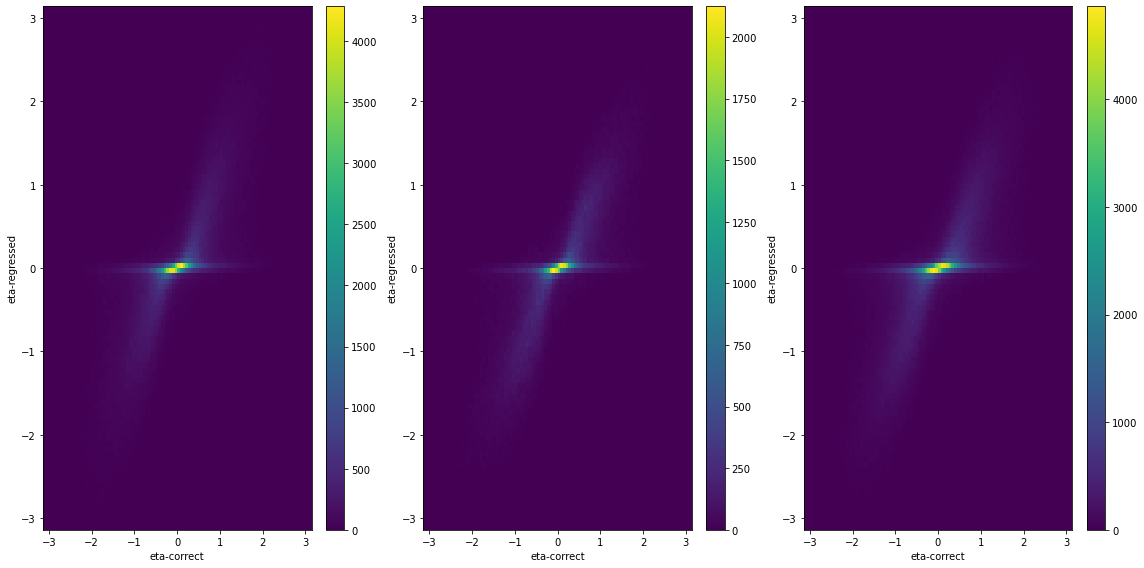

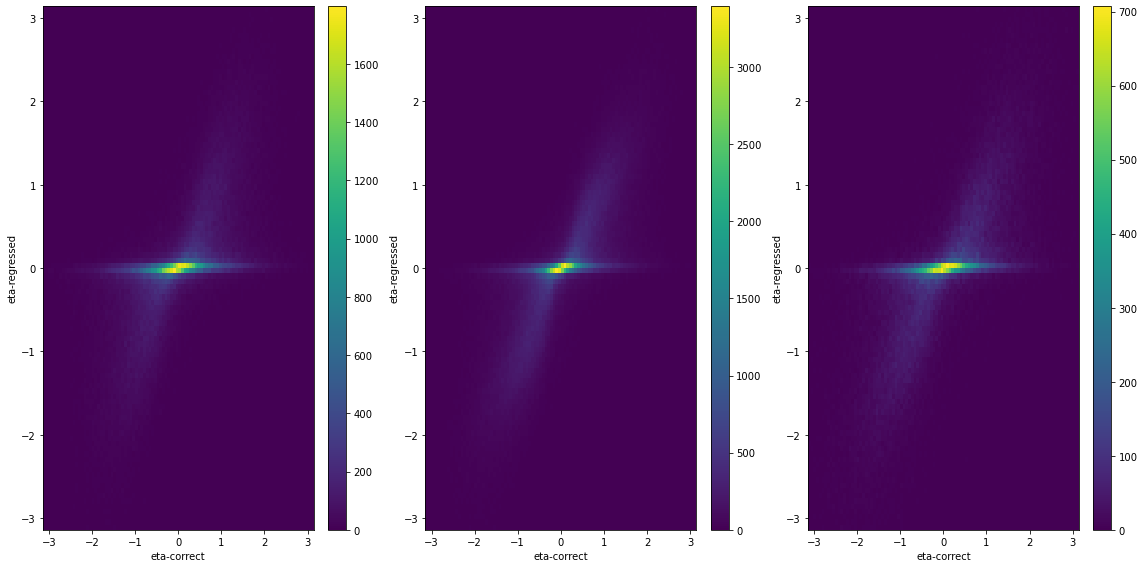

In [135]:
plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_eta(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

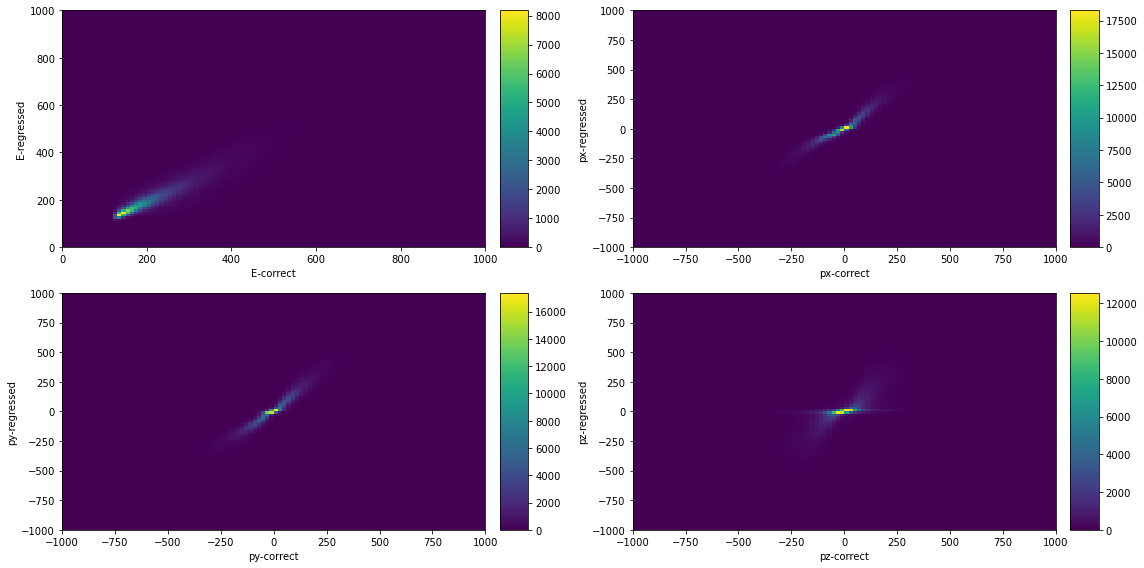

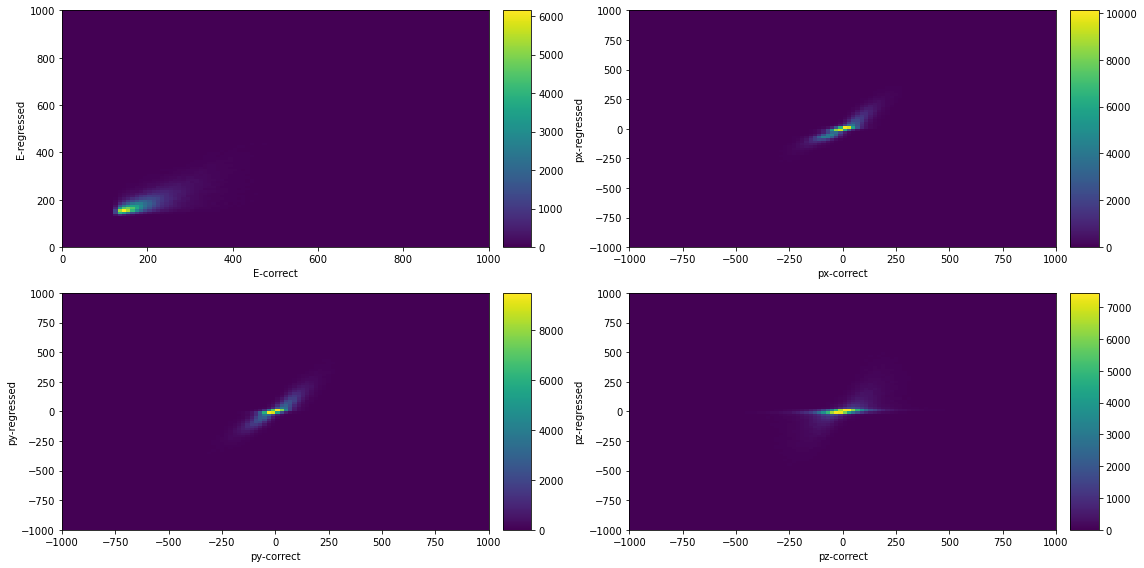

In [146]:
plot_particle(higgsCorrect, higgs, particle_mask = higgs_mask)

plot_particle(higgsCorrect, higgs, particle_mask = np.logical_not(higgs_mask))

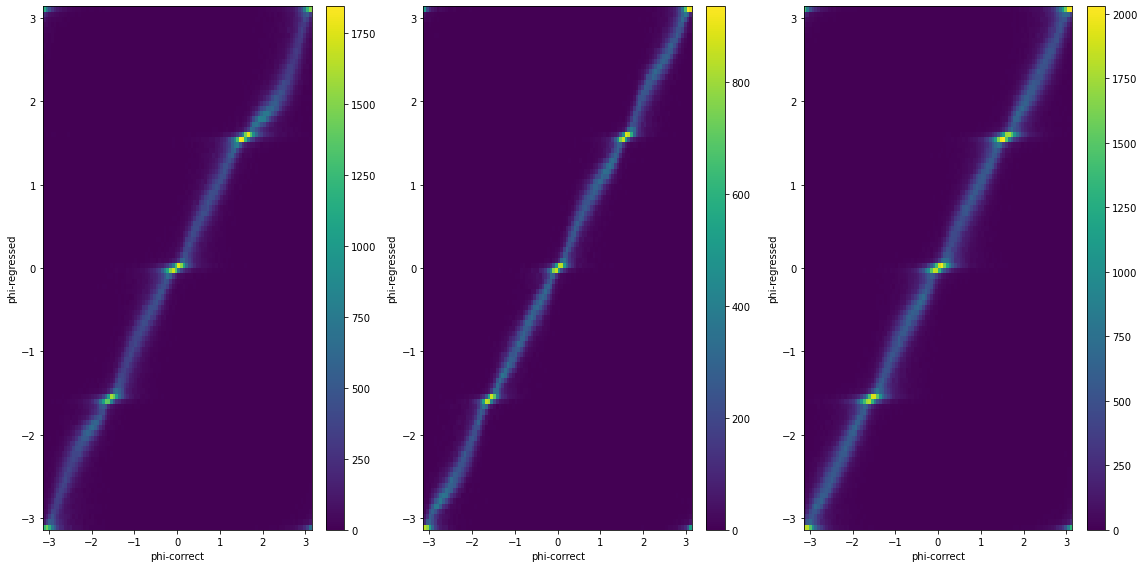

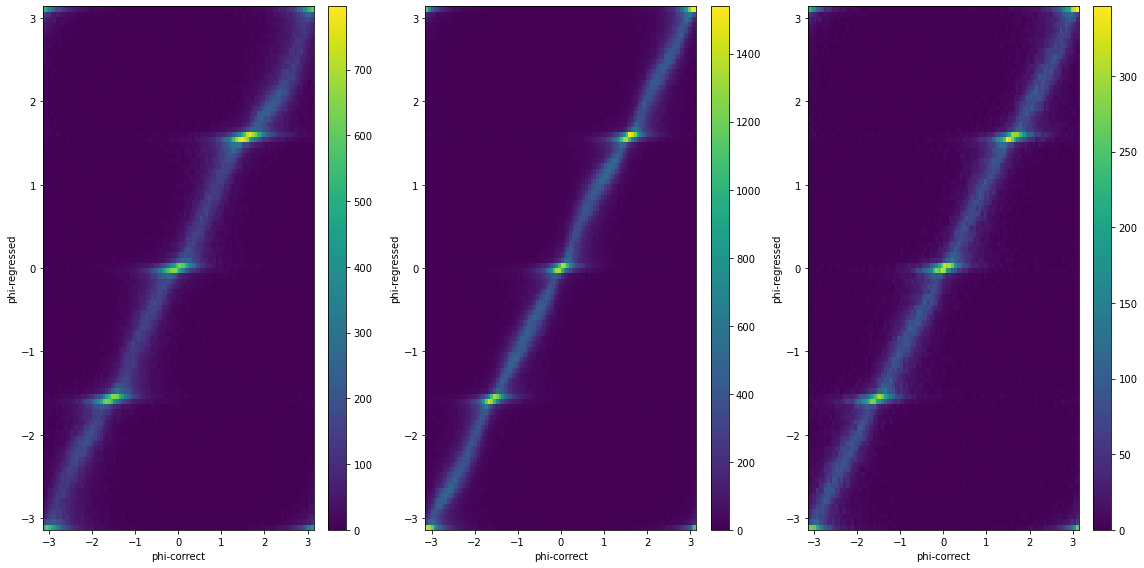

In [147]:
plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_phi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

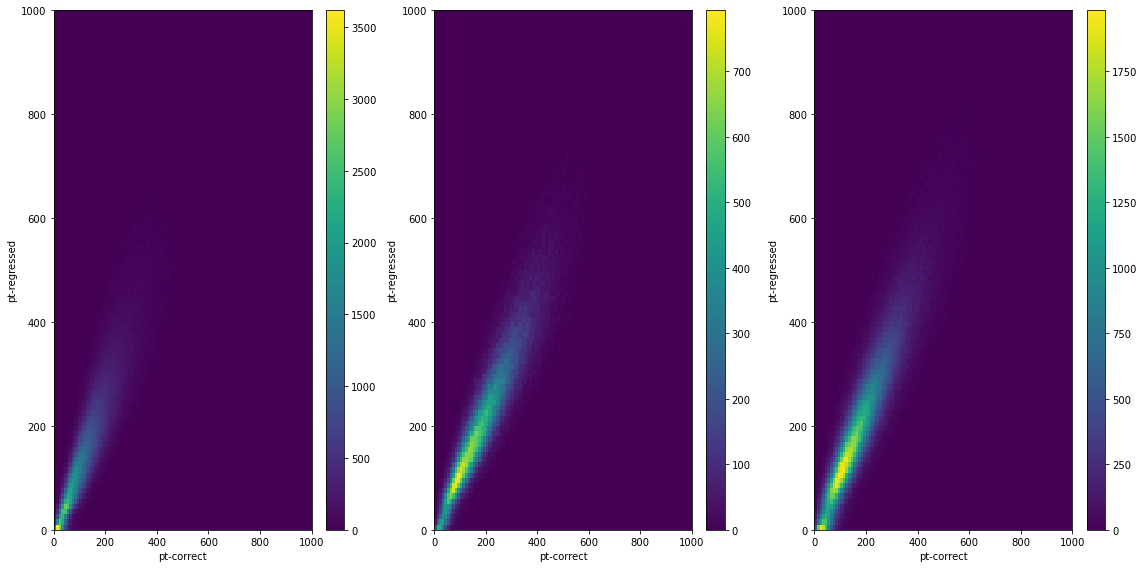

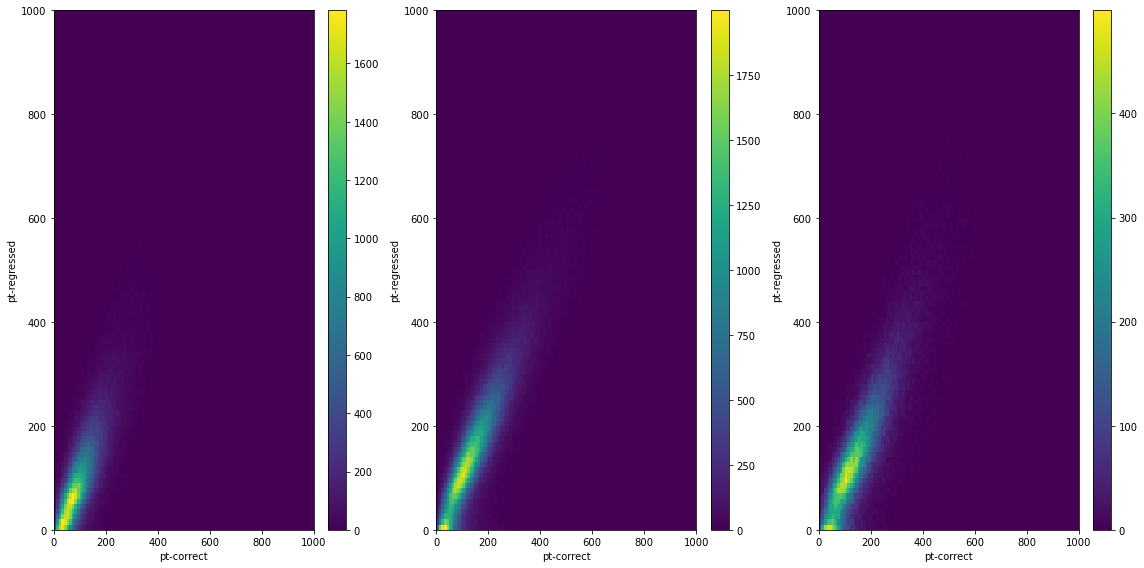

In [148]:
plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_pt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

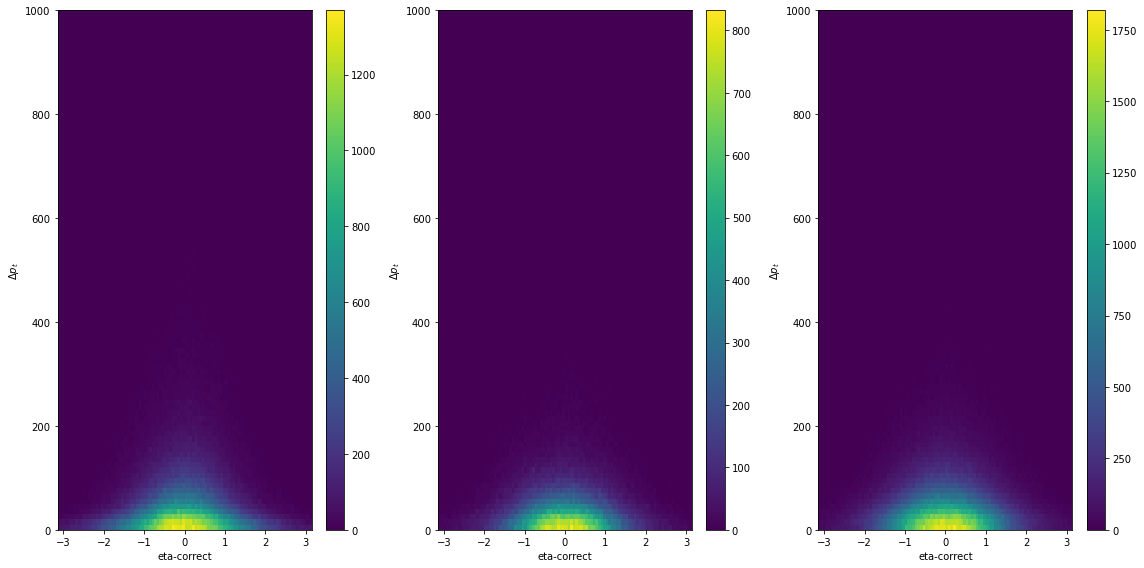

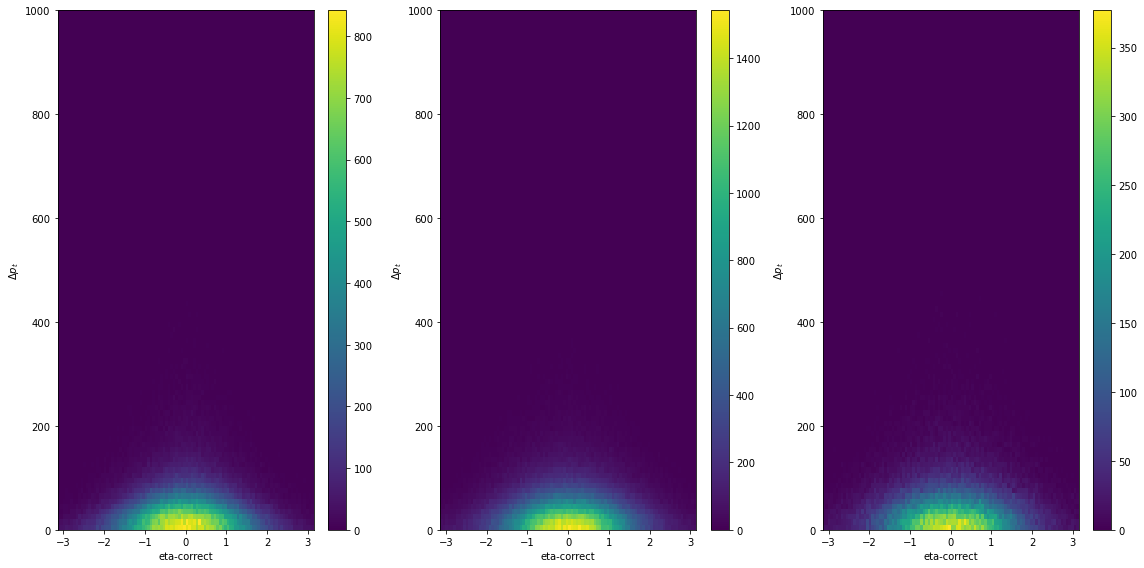

In [149]:
plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_eta_Diffpt(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

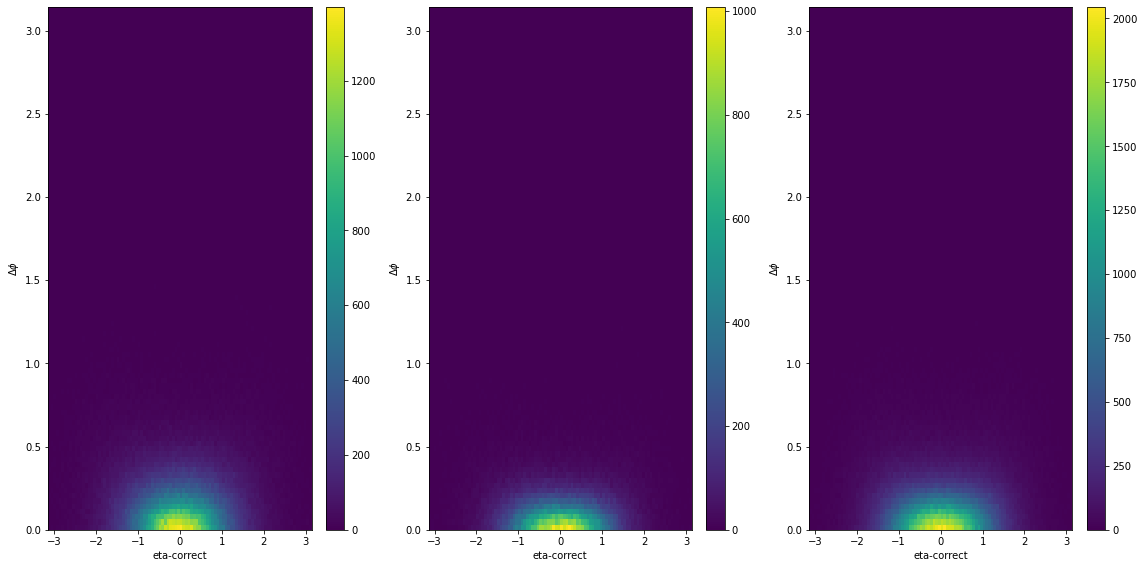

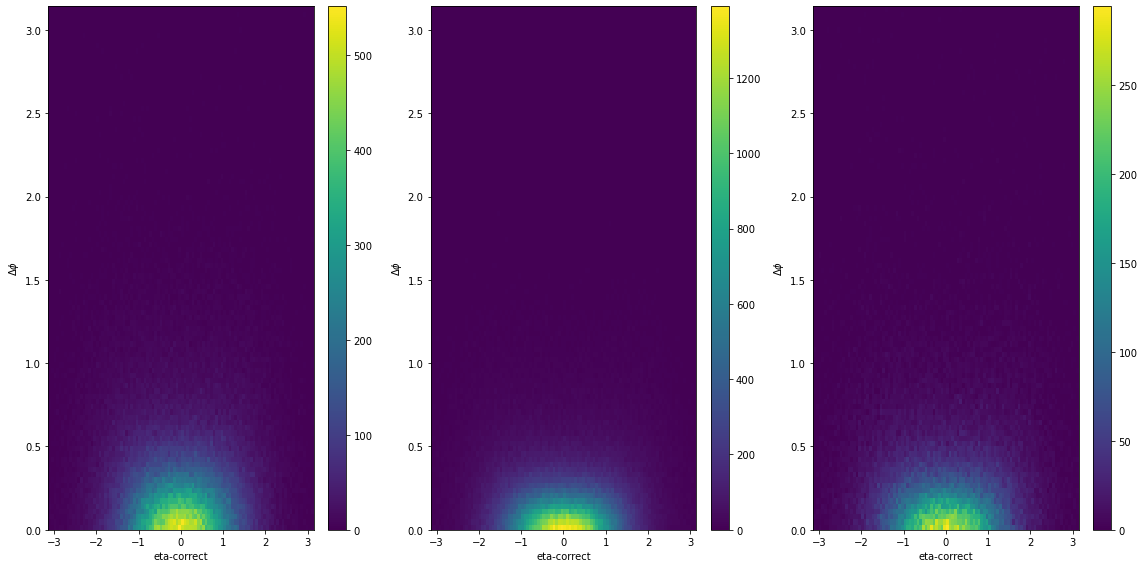

In [150]:
plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_eta_Diffphi(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

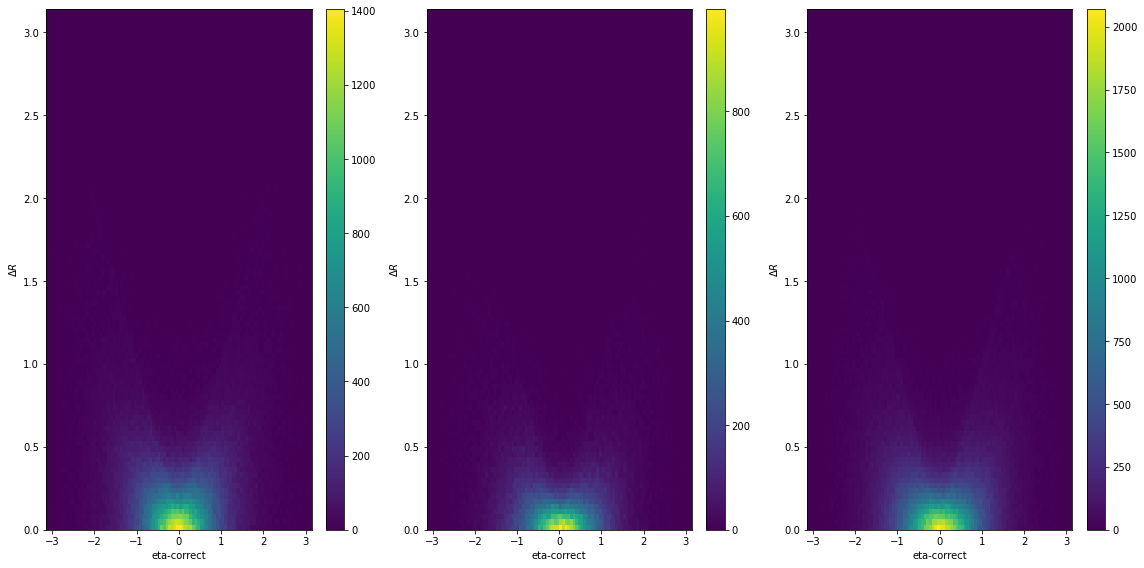

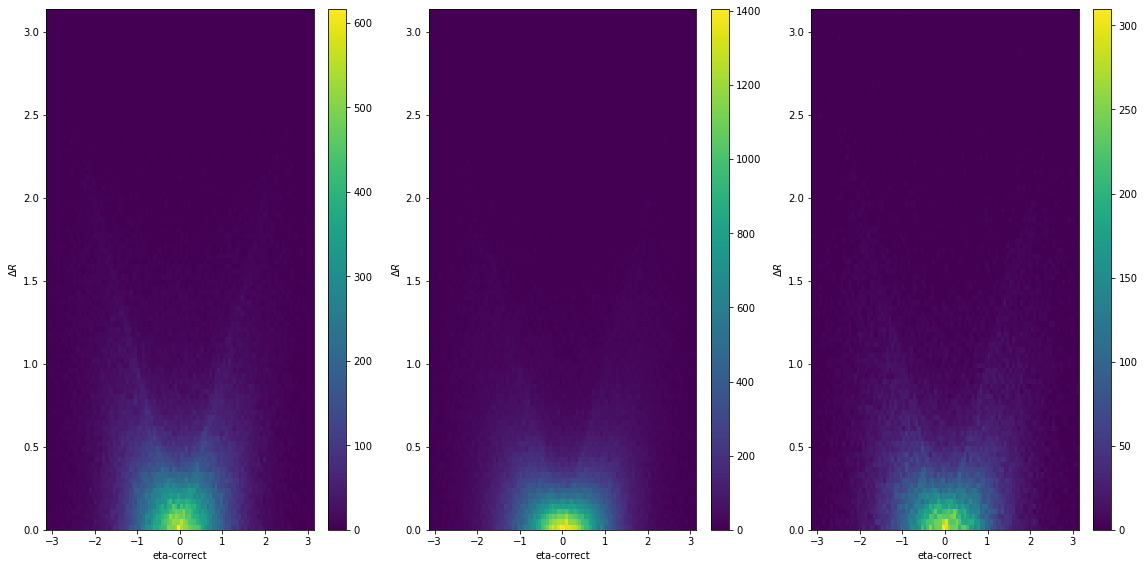

In [151]:
plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
         higgs_mask = higgs_mask, thad_mask = hadt_mask, tlep_mask = tlep_mask)

plot_eta_DiffR(higgsCorrect, higgs, thadCorrect, thad, tlepCorrect, tlep,
        higgs_mask = np.logical_not(higgs_mask),
         thad_mask = np.logical_not(hadt_mask),
         tlep_mask = np.logical_not(tlep_mask))

# Debug

In [17]:
data_debug = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=[],
                        parton_list=['data_higgs_t_tbar_ISR',
                                    'data_higgs_t_tbar_ISR_cartesian',
                                     'log_data_higgs_t_tbar_ISR_cartesian',
                                     'logScaled_data_higgs_t_tbar_ISR_cartesian',
                                    'mean_log_data_higgs_t_tbar_ISR_cartesian',
                                    'std_log_data_higgs_t_tbar_ISR_cartesian'])
        


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load log_data_higgs_t_tbar_ISR_cartesian
Load logScaled_data_higgs_t_tbar_ISR_cartesian


In [18]:
data_debug.parton_data.std_log_data_higgs_t_tbar_ISR_cartesian

tensor([0.7190, 4.1955, 4.1955, 4.6356])

In [19]:
data_debug.parton_data.mean_log_data_higgs_t_tbar_ISR_cartesian

tensor([ 5.4430e+00, -1.7112e-03, -2.6181e-03, -3.8758e-03])

In [20]:
logP_Befnow = data_debug.parton_data.data_higgs_t_tbar_ISR_cartesian
noCart = data_debug.parton_data.data_higgs_t_tbar_ISR

logP_now = torch.sign(logP_Befnow)*torch.log(1+torch.abs(logP_Befnow))

print(logP_now.shape)

torch.Size([569993, 4, 4])


In [21]:
logP = data_debug.parton_data.log_data_higgs_t_tbar_ISR_cartesian
print(logP.shape)

torch.Size([569993, 4, 4])


In [22]:
particle = 3
feature = 0

print(logP_Befnow[:,particle,feature])
print(logP[:,particle,feature])
print(logP_now[:,particle,feature])

tensor([ 50.6259,  30.6760,  82.0437,  ...,  68.2837, 151.4650,  90.3637])
tensor([3.9440, 3.4556, 4.4194,  ..., 4.2382, 5.0269, 4.5148])
tensor([3.9440, 3.4556, 4.4194,  ..., 4.2382, 5.0269, 4.5148])


In [23]:
for p in range(4):
    for i in range(4):
        print(f"[{p}, {i}]: {torch.sum(logP[:,p,i])}")

[0, 0]: 3069186.794916988
[0, 1]: -2706.5393327429183
[0, 2]: -1820.5260003380265
[0, 3]: -8753.598712810966
[1, 0]: 3259415.295752026
[1, 1]: 3607.5307422663946
[1, 2]: 4812.797455628917
[1, 3]: -2671.2437390763316
[2, 0]: 3268370.87617908
[2, 1]: -7562.078009007324
[2, 2]: -13346.64423044329
[2, 3]: -321.60774720063694
[3, 0]: 2812936.213164882
[3, 1]: 2759.5322109148624
[3, 2]: 4385.2220545753535
[3, 3]: 2909.656976793059


In [32]:
particle = 0
feature = 0

print(logP_Befnow[:,particle,1])
print(noCart[:,particle,0])
print(torch.cos(noCart[:,particle,2]))

print(logP[:,particle,0])
print('')
print(unscaledTensor[:,particle,feature].detach())
print(data_regressed[:,particle,feature].detach())

tensor([ -45.8886, -143.4538,   70.3318,  ...,   49.9386,   49.1797,
        -114.8525])
tensor([ 59.2402, 147.2656,  77.5312,  ..., 114.0313,  68.1992, 137.3906])
tensor([-0.7746, -0.9741,  0.9071,  ...,  0.4379,  0.7211, -0.8360])
tensor([5.0141, 5.3197, 5.0431,  ..., 5.3543, 4.9696, 5.2343])

tensor([5.3038, 5.1208, 5.0675,  ..., 0.0000, 0.0000, 0.0000])
tensor([200.0966, 166.4749, 157.7713,  ...,   0.0000,   0.0000,   0.0000])
